# PyTorch
### 수학적 계산 겸 신경망 구축 용 오픈 소스 라이브러리

- PyTorch Tensors
  - a = torch.tensor(mutable)
  - numpy의 ndarray 와 같은 다차원 배열
  - CUDA 지원 : gpu 연결
- 모듈
  - 자동 미분, 최적화, NN 모듈

</br>파이토치 쓰는 이유

- 넘파이와 유사, 파이썬 시스템과 통합 쉬움, 텐서플로우에 비해 디버깅 쉬움
- tensorflow의 잦은 변경 - 버전간 호환 어려움 .. 파이토치 더 선호
- 최적화 능력은 좀 떨어지나(이론적으로는) 하지만 실제 성능의 차이는 미비함. (단점)

In [9]:
import torch
#torch.cuda.is_available()

In [12]:
from torch import nn
from torch.utils.data import DataLoader #이거 인터넷에서 데이터 다운 받는 역할
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import random

In [18]:
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),)
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
)

In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat" ,
    5: "Sandal" ,
    6: "Shirt",
    7: "Sneaker",
    8: "Bag" ,
    9: "Ankle Boot",
}

In [39]:
training_data[0][1]
test_data[0][0].shape
training_data[0][0].shape
len(test_data)
len(training_data)

60000

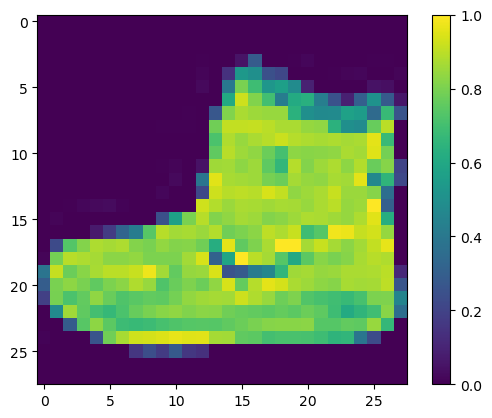

In [40]:
plt.figure()
plt.imshow(training_data[0][0].squeeze())
plt.colorbar()
plt.grid(False)
plt.show()

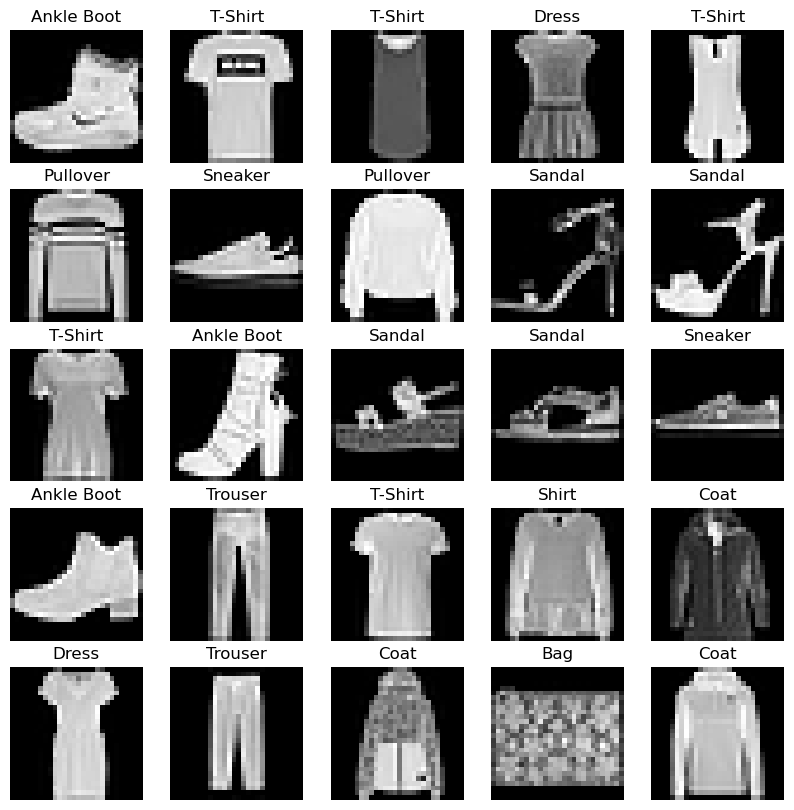

In [41]:
figure = plt.figure(figsize = (10,10))
cols, rows = 5,5
for i in range(1, cols * rows +1):
    sample_index = i -1
    img, label = training_data[sample_index]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

---
데이터 전처리
</br> dataloader  파이토치에서 데이터를 저장하고 불러오는 framework
</br></br>batch_size 한 번에 몇개씩 넣어서 학습시킬거냐



In [63]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X,y in test_dataloader:
    #학습 이미지 갯수, 채널 (흑백채널 - 1) , 사이즈
    print("Shape of x [N,C,H,W]:", X.shape)
    print("shape of y: ", y.shape, y.dtype)
    break

Shape of x [N,C,H,W]: torch.Size([64, 1, 28, 28])
shape of y:  torch.Size([64]) torch.int64


## 모델 구축
- 층을 조합하여 모델 구성

- 모델 구성 방법 : 사용자 정의 nn 모듈 -> 복잡한 신경망 설계에 적합  //nn.module을 상속한 클래스

- torch.nn.Module : weight와 forward....
  - init과 forward를 override해서 사용할 것임
  - _init()__: 모델에서 사용될 module, activation function등을 정의
  - forward(): 모델에서 수행해야할 계산을 정의

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

print(model)

using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


layer 종류 
linear layer - classification할 때 주로 사용
</br> cnn (convolution network)
</br> pooling -컨볼루션과 따라오는
</br> recurrent ...
</br> https://pytorch.org/docs/stable/nn.html#module
</br></br>활성화 함수의 종류
</br>non-linear activations - ReLU() : linear 많이 쌓아-> 사실상  한줄, 그렇기 때문에 리니어 사이사이에 넣을 것임. 
</br> 리니어 하지 않다는 것은 미분값이 일정하지 않은.
ReLU() 미분값이 간단해서 계산에 시간을 많이 안 잡아 먹으니까 주로 많이 사용함. 간단하게
그 외에도, sigmoid ..

---
### 손실 함수 및 최적화 방법 설정


In [65]:
#손실 함수 및 최적화 방법 설정
loss_fn = nn.CrossEntropyLoss() #작으면 작을 수록 실제 정답과 가깝다
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003) # 
#lr -> 학습을 진행시키는 속도, 가 작으면 작을수록 오래 걸리지만 값이 튈 확률 낮음
#주로 0.003 or 0.00


In [66]:
#학습 함수 정의
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred,y)
        #역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #100단위 출력
        if batch %100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss :>7f} [{current:>5d}/{size:5d}]")

In [69]:
#테스트 함수 정의
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            #모델을 통한 예측
            pred = model(X)
            #예측 결과 반영
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [70]:
#선언된 학습함수와 테스트 함수 사용
epochs= 5 #전체 데이터의 순회 횟수
for t in range(epochs):
    print(f"Epoch {t+1}\n ----------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("done!")

Epoch 1
 ----------------
loss: 0.322567 [    0/60000]
loss: 0.360693 [ 6400/60000]
loss: 0.285328 [12800/60000]
loss: 0.395481 [19200/60000]
loss: 0.415546 [25600/60000]
loss: 0.432553 [32000/60000]
loss: 0.354389 [38400/60000]
loss: 0.515389 [44800/60000]
loss: 0.390952 [51200/60000]
loss: 0.483658 [57600/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.405044 

Epoch 2
 ----------------
loss: 0.243831 [    0/60000]
loss: 0.334246 [ 6400/60000]
loss: 0.217416 [12800/60000]
loss: 0.330917 [19200/60000]
loss: 0.346405 [25600/60000]
loss: 0.387384 [32000/60000]
loss: 0.279469 [38400/60000]
loss: 0.444976 [44800/60000]
loss: 0.416108 [51200/60000]
loss: 0.346667 [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.410280 

Epoch 3
 ----------------
loss: 0.281131 [    0/60000]
loss: 0.294344 [ 6400/60000]
loss: 0.222448 [12800/60000]
loss: 0.285911 [19200/60000]
loss: 0.353565 [25600/60000]
loss: 0.330831 [32000/60000]
loss: 0.262221 [38400/60000]
loss: 0.402702 [44800/60000]
loss: 

In [72]:
#test_data에 대한 model의 추론 결과 획득
#예측 확률의 합이 1 이 되도록 soft max함수를 통한 정규화
with torch.no_grad():
    predictions = [nn.Softmax(dim=-1)(model(X.to(device))[0]) for X,y in test_data]

In [73]:
predictions[0]

tensor([2.6039e-06, 2.2825e-07, 4.3176e-09, 6.6376e-08, 4.6561e-10, 1.3883e-02,
        4.7886e-08, 1.7363e-02, 4.2300e-06, 9.6875e-01])

In [75]:
torch.argmax(predictions [0])  # 가장 높은 값

tensor(9)

---- 추론


In [83]:
def plot_image(i,predictions_array, data):
    predictions_array, true_label, img = predictions_array[i].cpu().numpy(),data[i][1],data[i][0].squeeze()
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"
    plt.xlabel("{} {:2.0f}% ({})".format(labels_map[predicted_label], 100 * np.max(predictions_array),labels_map[true_label]),color = color)

def plot_value_array(i, predictions_array, data):
    predictions_array, true_label = predictions_array[i].cpu().numpy(),data[i][1]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color = "#777777")
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

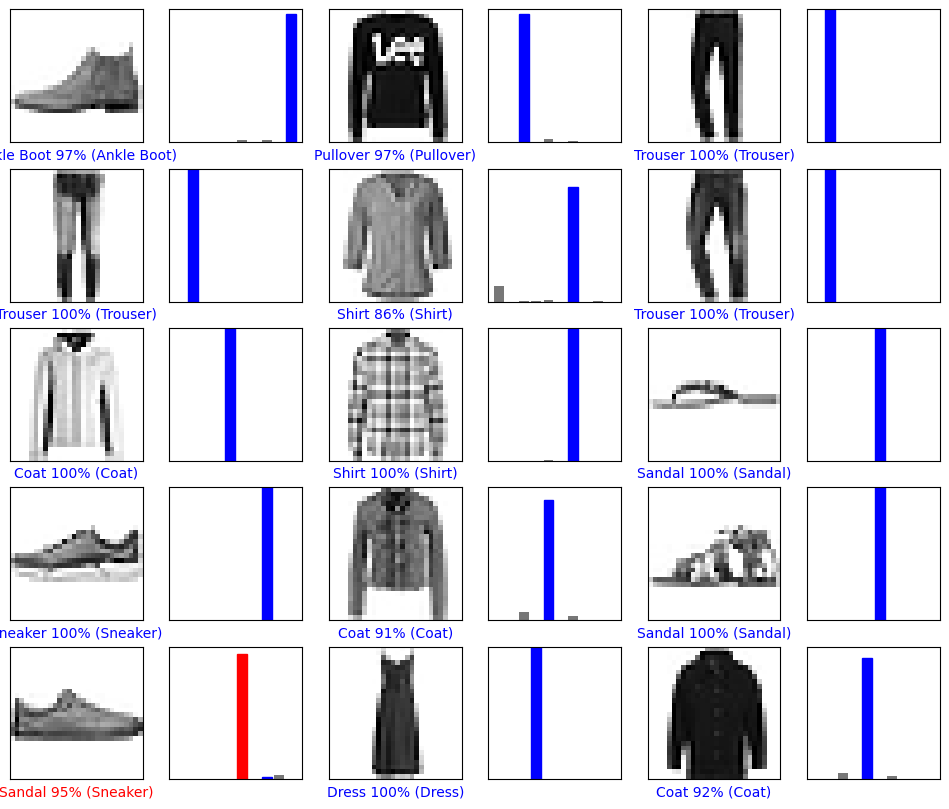

In [89]:
#추론
#처음 x개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
#올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize = (2*2*num_cols,2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i,predictions,test_data)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_data)
plt.show()

In [87]:
# torch.save(model.state_dict(), "./weights/my_model")
# model = NeuralNetwork()
# model.load_state_dict(torch.load("./weights/my_model"))